# 14장 - 텐서플로의 구조 자세히 알아보기

## 텐서플로의 주요 특징

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.17.1'

In [ ]:

a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')

z = 2*(a - b) + c
tf.print('결과: z =', z)

결과: z = 1


In [ ]:
import time
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('스칼라 입력:', compute_z(1, 2, 3))
tf.print('랭크 1 입력:', compute_z([1], [2], [3]))
tf.print('랭크 2 입력:', compute_z([[1]], [[2]], [[3]]))


스칼라 입력: 1
랭크 1 입력: [1]
랭크 2 입력: [[1]]


### 함수 데코레이터로 계산 성능 높이기

In [ ]:
@tf.function
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('스칼라 입력:', compute_z(1, 2, 3))
tf.print('랭크 1 입력:', compute_z([1], [2], [3]))
tf.print('랭크 2 입력:', compute_z([[1]], [[2]], [[3]]))

스칼라 입력: 1
랭크 1 입력: [1]
랭크 2 입력: [[1]]


## 모델 파라미터를 저장하고 업데이트하기 위한 텐서플로 변수 객체

In [ ]:
a = tf.Variable(initial_value=3.14, name='var_a')
b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
c = tf.Variable(initial_value=[True, False], dtype=tf.bool)
d = tf.Variable(initial_value=['abc'], dtype=tf.string)
print(a)
print(b)
print(c)
print(d)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


In [ ]:
a.trainable

True

In [ ]:
w = tf.Variable([1, 2, 3], trainable=False)

print(w.trainable)

False


In [ ]:
print(w.assign([3, 1, 4], read_value=True))
w.assign_add([2, -1, 2], read_value=False)

print(w.value())

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4], dtype=int32)>
tf.Tensor([5 0 6], shape=(3,), dtype=int32)


In [ ]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()

tf.print(init(shape=(3,)))

[1.01923072 -0.1556831 0.0738091692]


In [ ]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[1.11651134 -0.170542285 0.0808538944]
 [0.856661141 0.899256885 -0.13579756]]


In [ ]:
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)

m = MyModule()
print('모든 변수: ', [v.shape for v in m.variables])
print('훈련 가능한 변수:   ', [v.shape for v in
                        m.trainable_variables])

모든 변수:  [TensorShape([2, 3]), TensorShape([1, 2])]
훈련 가능한 변수:    [TensorShape([2, 3])]


In [ ]:
import tensorflow as tf

tf.random.set_seed(1)
w = tf.Variable(tf.random.uniform((3, 3)))

@tf.function
def compute_z(x):
    return tf.matmul(w, x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)
tf.print(compute_z(x))

[[3.8610158]
 [2.94593048]
 [3.82629013]]


## 자동 미분과 GradientTape을 사용해 그레이디언트 계산하기

### 훈련 가능한 변수에 대한 손실의 그레이디언트 계산하기

In [ ]:
import tensorflow as tf

w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)

tf.print('dL/dw : ', dloss_dw)

True True
dL/dw :  -0.559999764


In [ ]:
# 계산된 그레이디언트 확인

tf.print(2*x * ((w*x + b) - y))

[-0.559999764]


### 훈련하지 않는 변수에 대한 그레이디언트 계산하기

`tape.watch()`를 사용해 훈련하지 않는 텐서를 모니터링합니다

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.square(y - z)

dloss_dx = tape.gradient(loss, x)

tf.print('dL/dx:', dloss_dx)

dL/dx: [-0.399999857]


In [ ]:
# 계산된 그레이디언트 검증
tf.print(2*w * ((w*x + b) - y))

[-0.399999857]


### 여러 개의 그레이디언트 계산하기

`persistent=True`를 사용합니다.

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)

dL/dw: -0.559999764
dL/db: -0.399999857


#### 변수 업데이트: `optimizer.apply_gradients()`

In [ ]:
optimizer = tf.keras.optimizers.SGD()

optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

tf.print('업데이트된 w:', w)
tf.print('업데이트된 b:', b)

업데이트된 w: 1.0056
업데이트된 b: 0.504


## 케라스 API를 사용해 간단하게 일반적인 구조 구현하기

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

## 변수 지연 생성
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             544 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 624 (2.44 KB)

 Trainable params: 624 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## 모델의 변수 출력하기
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

kernel               True (4, 16)
bias                 True (16,)
kernel               True (16, 32)
bias                 True (32,)


In [ ]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=16,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.Constant(2.0)
    ))

model.add(
    tf.keras.layers.Dense(
        units=32,
        activation=tf.keras.activations.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l1
    ))

model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 16)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             544 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 624 (2.44 KB)

 Trainable params: 624 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),])

### XOR 분류 문제 풀어보기

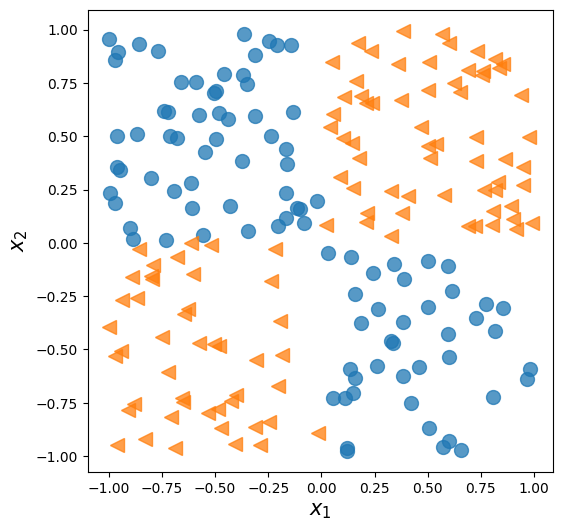

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0],
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0],
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                                activation='sigmoid'))

model.build(input_shape=(None, 2))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

<ipython-input-28-8e42762a545b>:19: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


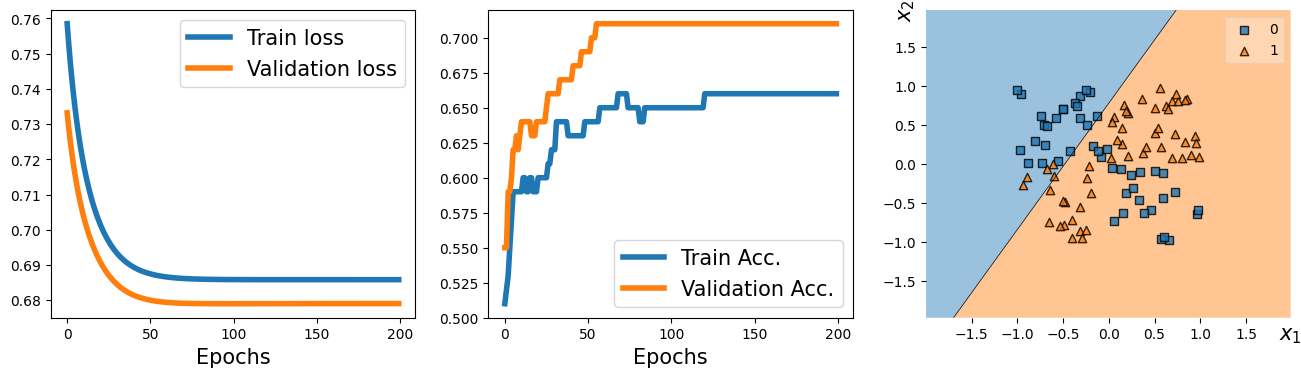

In [ ]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

In [ ]:
tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(2,)))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# model.build(input_shape=(None,2))

model.summary()

## 컴파일:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## 훈련:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

history = hist.history

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

<ipython-input-30-da2e0ce846ef>:15: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step


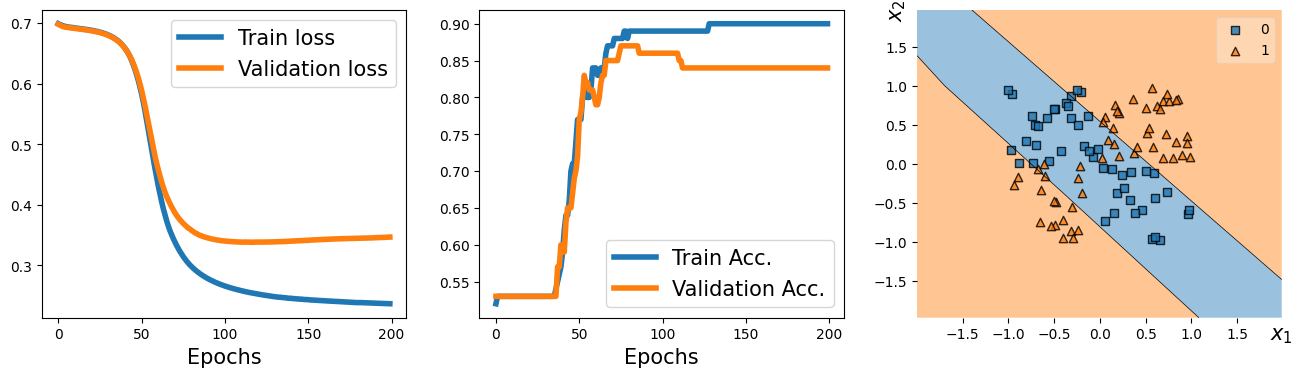

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
# plt.savefig('images/14_3.png', dpi=300)
plt.show()

### 케라스 함수형 API로 유연성이 높은 모델 만들기

### 케라사의 Model 클래스 기반으로 모델 만들기

#### `tf.keras.Model` 클래스 상속

 * `__init__()` 구현
 * `call()` 구현

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.input_layer = tf.keras.layers.Input(shape=(None,2))
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')

    def call(self, inputs):
        h = inputs
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

tf.random.set_seed(1)

## 테스트
model = MyModel()

model.summary()

## 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## 훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

## 그래프 그리기
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### MNIST 데이터를 이용하여 딥러닝으로 숫자인식 프로그램 만들기

In [ ]:
# 데이터 전처리/ shuffle, 위에 만들어진 My Model 이용해서 test 데이터 집어넣고 Accuracy 까지...
# 코드 복사, 결과 복사해서 Word에 정리해서 내기..
# 월요일 밤 12시까지..

##1. 데이터 불러오기

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
X = ((X / 255.) - .5) * 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

In [6]:
import numpy as np

np.savez_compressed('mnist_scaled.npz',
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [7]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [8]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train',
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

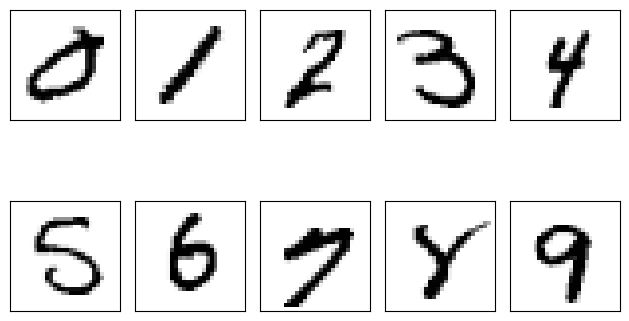

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X_train[y_train == i][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

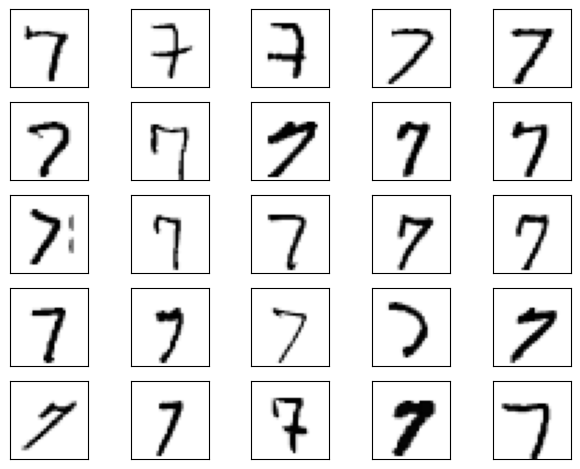

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    # Use .iloc to access the data by position after filtering
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

## 모델 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
## 모델의 변수 출력하기
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

kernel               True (4, 4)
bias                 True (4,)
kernel               True (4, 4)
bias                 True (4,)
kernel               True (4, 4)
bias                 True (4,)
kernel               True (4, 1)
bias                 True (1,)


In [17]:
import tensorflow as tf

# Define the model
model = tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Dense(
    units=64,  # Increased units
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.GlorotNormal(),
    bias_initializer=tf.keras.initializers.Constant(2.0),
    input_shape=(784,)  # Input shape specified only in the first layer
))

# Additional hidden layers
model.add(tf.keras.layers.Dense(units=128, activation='relu'))  # Increased capacity
model.add(tf.keras.layers.Dense(units=64, activation='relu'))   # Add another hidden layer

# Output layer
model.add(tf.keras.layers.Dense(
    units=10,  # Output units should match the number of classes
    activation='softmax'  # Use softmax for multi-class classification
))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(
    x=X_train[:15000],  # Training samples
    y=y_train[:15000],  # Training labels
    validation_data=(X_train[15000:25000], y_train[15000:25000]),  # Validation samples
    epochs=20  # Increase epochs for deeper networks
)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7029 - loss: 0.9423 - val_accuracy: 0.8773 - val_loss: 0.3870
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9071 - loss: 0.2929 - val_accuracy: 0.9165 - val_loss: 0.2711
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9383 - loss: 0.2080 - val_accuracy: 0.9251 - val_loss: 0.2375
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9462 - loss: 0.1644 - val_accuracy: 0.9442 - val_loss: 0.1832
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9522 - loss: 0.1477 - val_accuracy: 0.9324 - val_loss: 0.2273
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9586 - loss: 0.1226 - val_accuracy: 0.9320 - val_loss: 0.2231
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.1125 - val_accuracy: 0.9421 - val_loss: 0.1905
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9718 - loss: 0.0878 - val_accuracy: 0.

In [21]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,400 (790.63 KB)

 Trainable params: 67,466 (263.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 134,934 (527.09 KB)

In [22]:
import numpy as np

y_test_pred = model.predict(X_test)
# Get the predicted class labels by finding the index of the maximum value along the second axis (axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float32) / X_test.shape[0])

print('Test Accuracy: %.2f%%' % (acc * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Accuracy: 96.10%


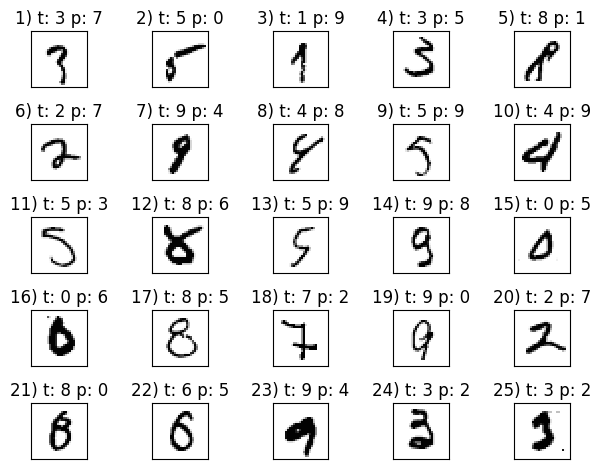

In [20]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()